In [1]:
%env CUDA_VISIBLE_DEVICES=6
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=6


In [2]:
def to_onehot(data, n_digits):
    d = torch.tensor(data)
    y = torch.zeros(d.shape[0], n_digits).scatter(1,d[:,None],1)
    return y

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
root_folder = 'FC_CAAE_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [5]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cuda:0


In [7]:
data, label = next(iter(train_loader))

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, bn=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if bn:
                layers.append(nn.BatchNorm1d(sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [9]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size+10, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [10]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [11]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [12]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10).to(device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10).to(device)

        fake_pred = Disc(Enc(data), label)
        true_pred = Disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10)
        
        latent = Enc(data)
        reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
        fake_pred = Disc(latent, label)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [13]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10).to(device)
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10).to(device)
            latent = Enc(data)
            reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
            fake_pred = Disc(latent, label)
            true_pred = Disc(z, z_label)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size

        if epoch % 20 == 0:
            fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
            plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
            fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
            plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.6834, AE: 0.9273, D: 0.6981
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 0.8005, AE: 0.2840, D: 4.1426
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.8233, AE: 0.2729, D: 1.2929
Test losses. E: 0.8174, AE: 0.2717, D: 1.2593
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.8198, AE: 0.2758, D: 1.2352
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.6475, AE: 0.2522, D: 0.9298
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 0.4946, AE: 0.2536, D: 0.8451
Test losses. E: 0.4287, AE: 0.2486, D: 0.8781
Train Epoch: 3 [0/50000 (0%)]	Losses E: 0.4721, AE: 0.2399, D: 0.8721
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 0.8197, AE: 0.2466, D: 0.8673
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5685, AE: 0.2402, D: 0.7709
Test losses. E: 0.5622, AE: 0.2314, D: 0.7591
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5661, AE: 0.2333, D: 0.7684
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.5103, AE: 0.2216, D: 0.7590
Train Epoch: 4 [50000/50000 (100%)]	Losses E: 0.7446, 

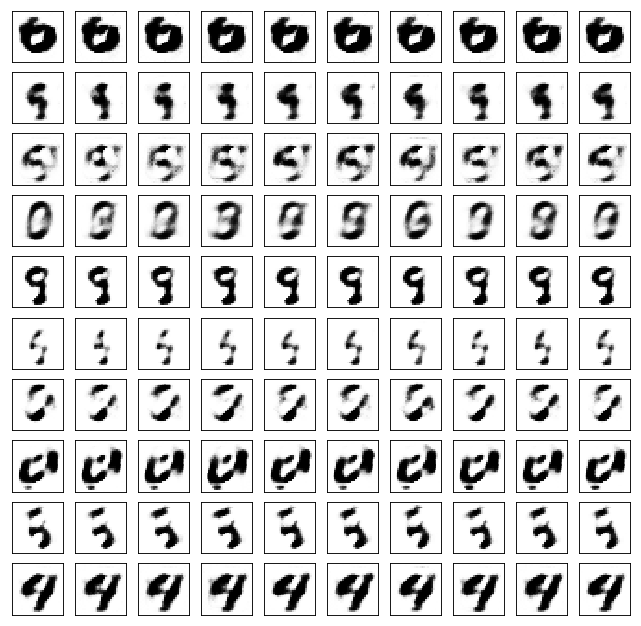

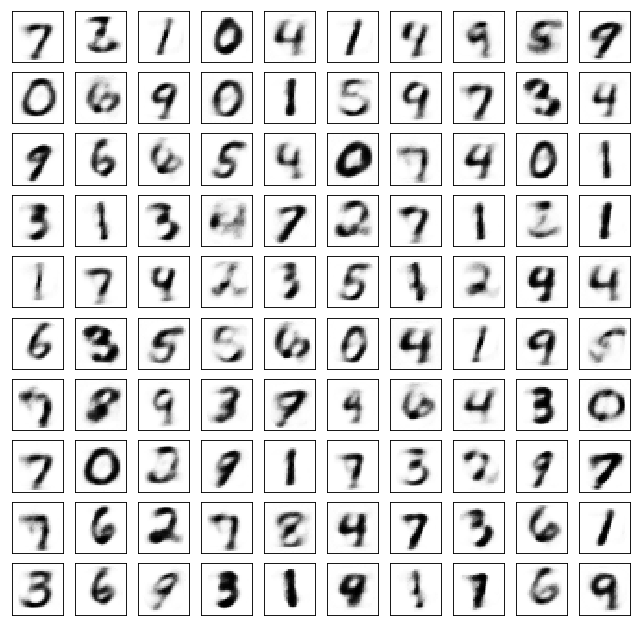

Test losses. E: 0.6704, AE: 0.1164, D: 0.6790
Train Epoch: 21 [0/50000 (0%)]	Losses E: 0.6708, AE: 0.1186, D: 0.6791
Train Epoch: 21 [25000/50000 (50%)]	Losses E: 0.2789, AE: 0.2479, D: 1.1587
Train Epoch: 21 [50000/50000 (100%)]	Losses E: 0.7383, AE: 0.1434, D: 0.7328
Test losses. E: 0.7379, AE: 0.1365, D: 0.7285
Train Epoch: 22 [0/50000 (0%)]	Losses E: 0.7347, AE: 0.1385, D: 0.7311
Train Epoch: 22 [25000/50000 (50%)]	Losses E: 0.6475, AE: 0.1259, D: 0.6904
Train Epoch: 22 [50000/50000 (100%)]	Losses E: 0.7567, AE: 0.1833, D: 0.6947
Test losses. E: 0.7325, AE: 0.1760, D: 0.6984
Train Epoch: 23 [0/50000 (0%)]	Losses E: 0.7420, AE: 0.1670, D: 0.6987
Train Epoch: 23 [25000/50000 (50%)]	Losses E: 0.6678, AE: 0.1414, D: 0.7468
Train Epoch: 23 [50000/50000 (100%)]	Losses E: 0.6875, AE: 0.1389, D: 0.6897
Test losses. E: 0.6824, AE: 0.1384, D: 0.6897
Train Epoch: 24 [0/50000 (0%)]	Losses E: 0.6871, AE: 0.1358, D: 0.6882
Train Epoch: 24 [25000/50000 (50%)]	Losses E: 0.7002, AE: 0.1361, D: 0.71

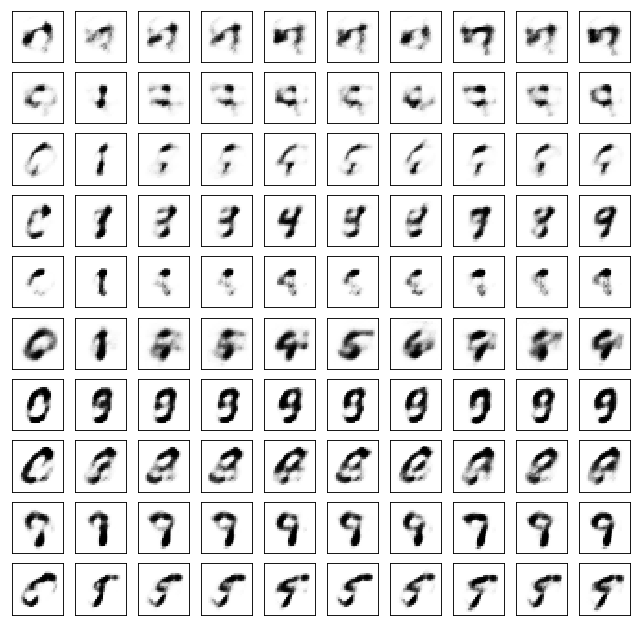

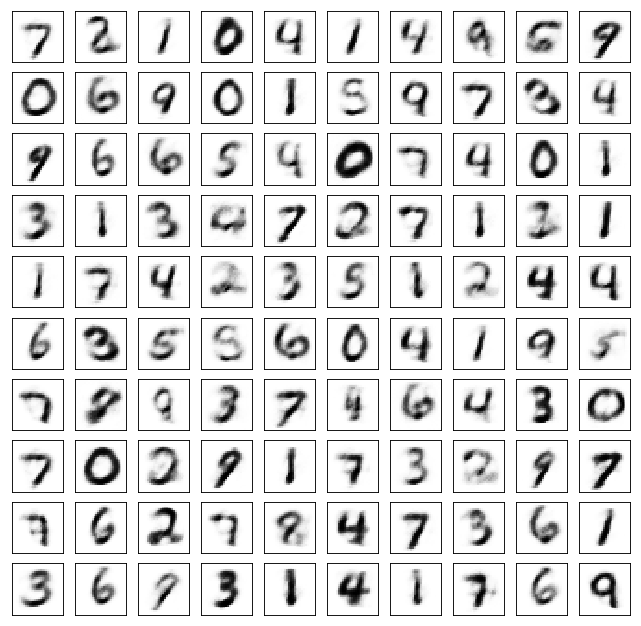

Test losses. E: 0.7018, AE: 0.1233, D: 0.7215
Train Epoch: 41 [0/50000 (0%)]	Losses E: 0.7015, AE: 0.1221, D: 0.7191
Train Epoch: 41 [25000/50000 (50%)]	Losses E: 0.6716, AE: 0.1131, D: 0.7028
Train Epoch: 41 [50000/50000 (100%)]	Losses E: 0.7076, AE: 0.1059, D: 0.6930
Test losses. E: 0.7042, AE: 0.1059, D: 0.6917
Train Epoch: 42 [0/50000 (0%)]	Losses E: 0.7060, AE: 0.1081, D: 0.6904
Train Epoch: 42 [25000/50000 (50%)]	Losses E: 0.7409, AE: 0.1097, D: 0.6888
Train Epoch: 42 [50000/50000 (100%)]	Losses E: 0.7225, AE: 0.1062, D: 0.6908
Test losses. E: 0.7210, AE: 0.1036, D: 0.6903
Train Epoch: 43 [0/50000 (0%)]	Losses E: 0.7217, AE: 0.1022, D: 0.6928
Train Epoch: 43 [25000/50000 (50%)]	Losses E: 0.6625, AE: 0.1049, D: 0.7114
Train Epoch: 43 [50000/50000 (100%)]	Losses E: 0.6859, AE: 0.1019, D: 0.6791
Test losses. E: 0.6795, AE: 0.0996, D: 0.6815
Train Epoch: 44 [0/50000 (0%)]	Losses E: 0.6843, AE: 0.1022, D: 0.6825
Train Epoch: 44 [25000/50000 (50%)]	Losses E: 0.6985, AE: 0.0961, D: 0.68

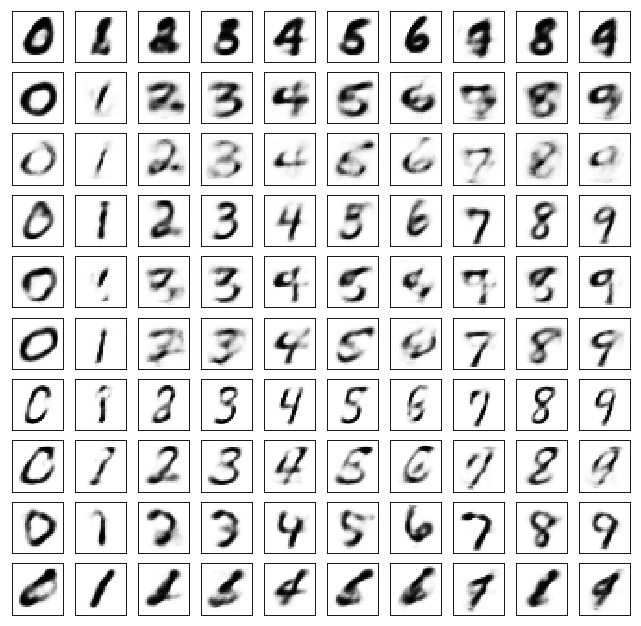

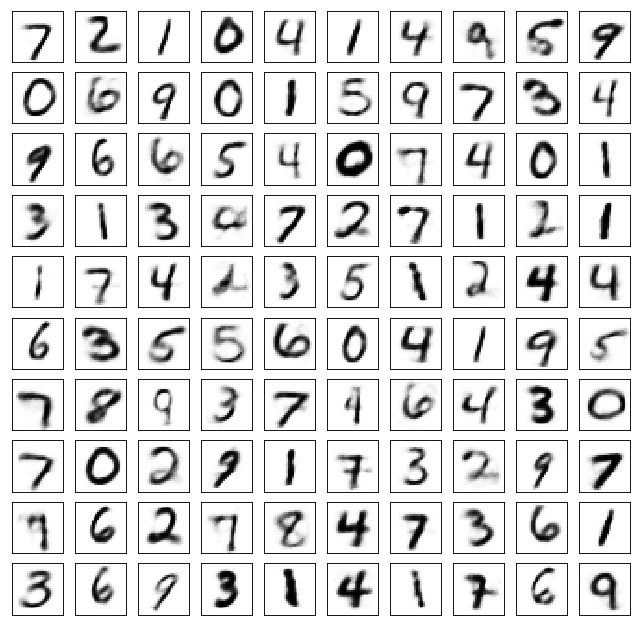

Test losses. E: 0.7031, AE: 0.0816, D: 0.6953
Train Epoch: 61 [0/50000 (0%)]	Losses E: 0.7022, AE: 0.0793, D: 0.6967
Train Epoch: 61 [25000/50000 (50%)]	Losses E: 0.7153, AE: 0.0776, D: 0.6938
Train Epoch: 61 [50000/50000 (100%)]	Losses E: 0.7135, AE: 0.0841, D: 0.6982
Test losses. E: 0.7118, AE: 0.0819, D: 0.6968
Train Epoch: 62 [0/50000 (0%)]	Losses E: 0.7166, AE: 0.0800, D: 0.6946
Train Epoch: 62 [25000/50000 (50%)]	Losses E: 0.6746, AE: 0.0734, D: 0.6917
Train Epoch: 62 [50000/50000 (100%)]	Losses E: 0.7019, AE: 0.0827, D: 0.6953
Test losses. E: 0.7013, AE: 0.0808, D: 0.6944
Train Epoch: 63 [0/50000 (0%)]	Losses E: 0.7041, AE: 0.0831, D: 0.6948
Train Epoch: 63 [25000/50000 (50%)]	Losses E: 0.7209, AE: 0.0749, D: 0.6940
Train Epoch: 63 [50000/50000 (100%)]	Losses E: 0.7782, AE: 0.0928, D: 0.6900
Test losses. E: 0.7724, AE: 0.0926, D: 0.6914
Train Epoch: 64 [0/50000 (0%)]	Losses E: 0.7759, AE: 0.0960, D: 0.6915
Train Epoch: 64 [25000/50000 (50%)]	Losses E: 0.7060, AE: 0.0923, D: 0.68

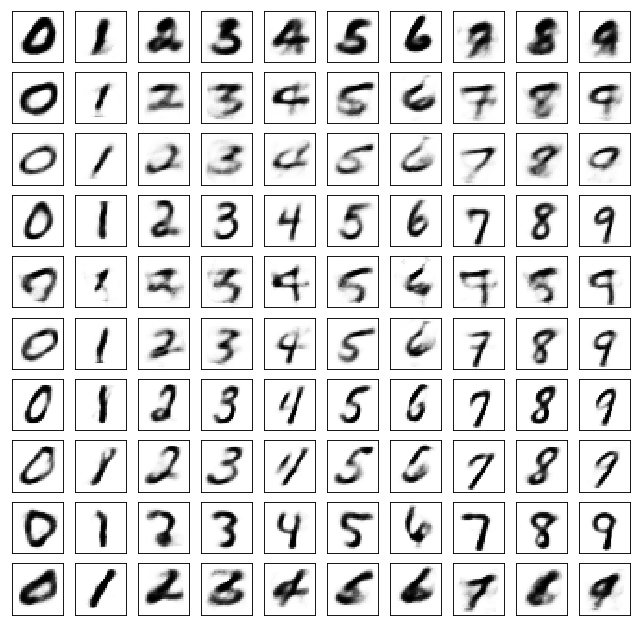

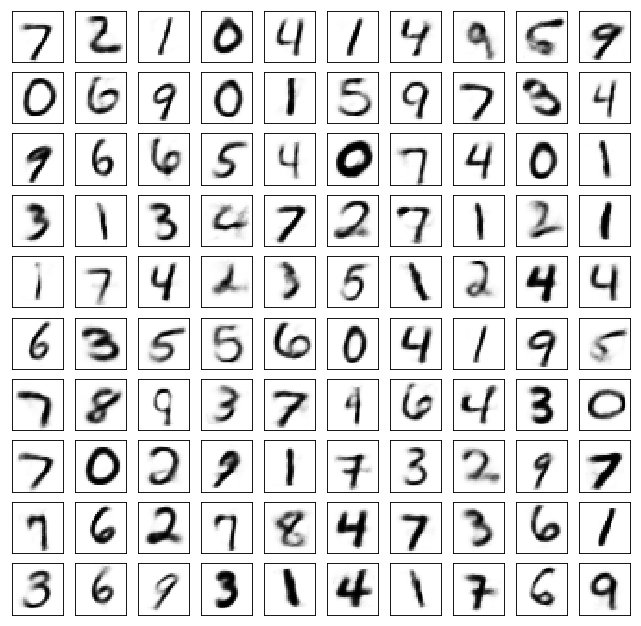

Test losses. E: 0.7150, AE: 0.0709, D: 0.6930
Train Epoch: 81 [0/50000 (0%)]	Losses E: 0.7194, AE: 0.0638, D: 0.6923
Train Epoch: 81 [25000/50000 (50%)]	Losses E: 0.6799, AE: 0.0732, D: 0.6987
Train Epoch: 81 [50000/50000 (100%)]	Losses E: 0.6925, AE: 0.0700, D: 0.6926
Test losses. E: 0.6897, AE: 0.0676, D: 0.6930
Train Epoch: 82 [0/50000 (0%)]	Losses E: 0.6892, AE: 0.0622, D: 0.6925
Train Epoch: 82 [25000/50000 (50%)]	Losses E: 0.7242, AE: 0.0701, D: 0.6943
Train Epoch: 82 [50000/50000 (100%)]	Losses E: 0.6899, AE: 0.0645, D: 0.6956
Test losses. E: 0.6892, AE: 0.0685, D: 0.6941
Train Epoch: 83 [0/50000 (0%)]	Losses E: 0.6900, AE: 0.0661, D: 0.6942
Train Epoch: 83 [25000/50000 (50%)]	Losses E: 0.6812, AE: 0.0681, D: 0.6977
Train Epoch: 83 [50000/50000 (100%)]	Losses E: 0.7158, AE: 0.0699, D: 0.6932
Test losses. E: 0.7152, AE: 0.0677, D: 0.6934
Train Epoch: 84 [0/50000 (0%)]	Losses E: 0.7156, AE: 0.0581, D: 0.6923
Train Epoch: 84 [25000/50000 (50%)]	Losses E: 0.6944, AE: 0.0683, D: 0.69

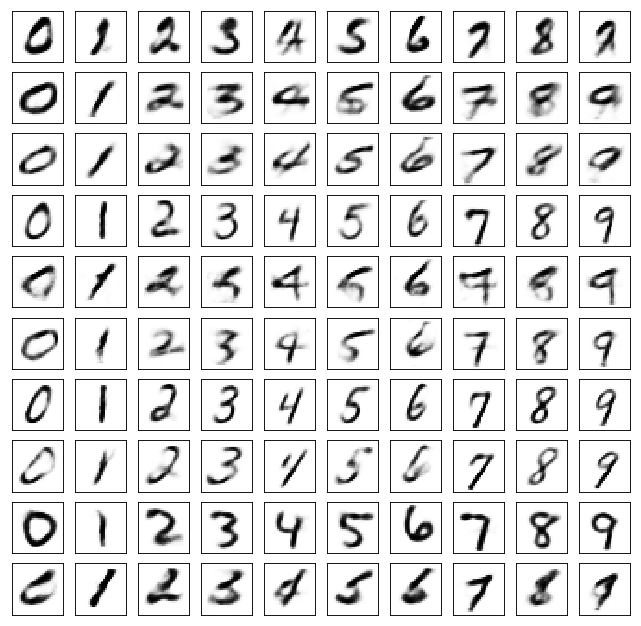

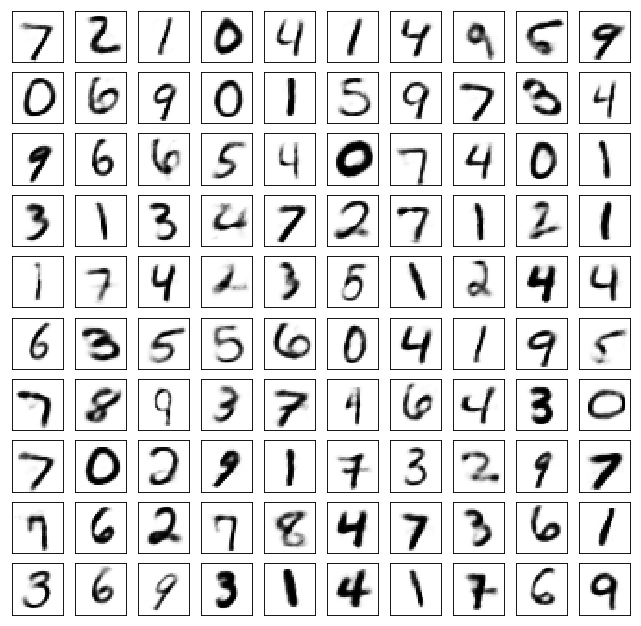

Test losses. E: 0.6935, AE: 0.0629, D: 0.6915


In [14]:
for epoch in range(1, 101):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)

In [15]:
torch.save(Enc.state_dict(),'caae_enc.100e.pt')
torch.save(Dec.state_dict(),'caae_dec.100e.pt')
torch.save(Disc.state_dict(),'caae_disc.100e.pt')

## Train classifiers on original images and latent representation

In [16]:
class Classifier(nn.Module):
    def __init__(self, sizes, flatten = False):
        super().__init__()
        self.fc = FullyConnected(sizes, 
                                 activation_fn=nn.ReLU(), 
                                 last_fn=nn.LogSoftmax(dim=1),
                                 dropout = 0.2,
                                 bn=True, 
                                 flatten=flatten)
        self.optim = optim.Adam(self.fc.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = self.fc(x)
        return x

In [17]:
def train_clf(epoch, clf, loader):
    train_loss = 0.0
    train_accuracy = 0.0
    total_samples = 0.0
    clf.train()
    for batch, (data, label) in enumerate(loader):
        clf.optim.zero_grad()
        data = torch.tensor(data).cuda()
        label = torch.tensor(label).cuda()
        
        output = clf(data)
        loss = F.nll_loss(output, label)
        loss.backward()
        clf.optim.step()
        
        train_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        train_accuracy += (pred == label).sum().item()
        total_samples += data.shape[0]

    train_loss /= len(train_data)
    print("Epoch {:2d}: loss {:.4f}, accuracy {:.2f}%".format(epoch, train_loss, 100 * train_accuracy/ total_samples))

In [18]:
def test_clf(epoch, clf, loader):
    test_loss = 0.0
    test_accuracy = 0.0
    total_samples = 0.0
    clf.eval()
    for batch, (data, label) in enumerate(loader):
        data = torch.tensor(data).cuda()
        label = torch.tensor(label).cuda()
        
        output = clf(data)
        loss = F.nll_loss(output, label)
                
        test_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        test_accuracy += (pred == label).sum().item()
        total_samples += data.shape[0]

    test_loss /= len(test_data)
    print("Test  {:2d}: loss {:.4f}, accuracy {:.2f}%".format(epoch, test_loss, 100 * test_accuracy / total_samples))

### Create train/test dataset from latent representation

In [19]:
Enc.eval()
train_data = []
test_data = []
for data, label in train_loader:
    data = data.cuda()
    train_data.append((Enc(data).data.cpu().numpy(), label.data.numpy()))
    
for data, label in test_loader:
    data = data.cuda()
    test_data.append((Enc(data).data.cpu().numpy(), label.data.numpy()))    

### Train classifier on original images

In [20]:
image_clf = Classifier([28*28, 2048, 1024, 512, 10], flatten=True).cuda()
image_clf

Classifier(
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=784, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=1024, bias=True)
      (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.2)
      (7): ReLU()
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Dropout(p=0.2)
      (11): ReLU()
      (12): Linear(in_features=512, out_features=10, bias=True)
      (13): LogSoftmax()
    )
  )
)

In [21]:
for epoch in range(1,11):
    train_clf(epoch, image_clf, train_loader)
    test_clf(epoch, image_clf, test_loader)

Epoch  1: loss 0.6222, accuracy 88.04%
Test   1: loss 0.2250, accuracy 95.30%
Epoch  2: loss 0.1940, accuracy 95.83%
Test   2: loss 0.1227, accuracy 96.94%
Epoch  3: loss 0.1137, accuracy 97.43%
Test   3: loss 0.0882, accuracy 97.51%
Epoch  4: loss 0.0784, accuracy 98.14%
Test   4: loss 0.0731, accuracy 97.89%
Epoch  5: loss 0.0550, accuracy 98.68%
Test   5: loss 0.0651, accuracy 97.95%
Epoch  6: loss 0.0418, accuracy 99.07%
Test   6: loss 0.0643, accuracy 97.92%
Epoch  7: loss 0.0319, accuracy 99.27%
Test   7: loss 0.0601, accuracy 97.95%
Epoch  8: loss 0.0241, accuracy 99.49%
Test   8: loss 0.0654, accuracy 97.97%
Epoch  9: loss 0.0193, accuracy 99.59%
Test   9: loss 0.0584, accuracy 98.18%
Epoch 10: loss 0.0153, accuracy 99.72%
Test  10: loss 0.0627, accuracy 97.95%


### Train classifier on latent representation

In [22]:
latent_clf = Classifier([prior_size, 2048, 1024, 512, 10]).cuda()
latent_clf

Classifier(
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=10, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=1024, bias=True)
      (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.2)
      (7): ReLU()
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Dropout(p=0.2)
      (11): ReLU()
      (12): Linear(in_features=512, out_features=10, bias=True)
      (13): LogSoftmax()
    )
  )
)

In [23]:
for epoch in range(1,31):
    latent_clf.train()
    train_clf(epoch, latent_clf, train_data)
    latent_clf.eval()
    test_clf(epoch, latent_clf, test_data)

Epoch  1: loss 1.9110, accuracy 34.36%
Test   1: loss 1.6696, accuracy 43.75%
Epoch  2: loss 1.6109, accuracy 45.45%
Test   2: loss 1.4556, accuracy 51.11%
Epoch  3: loss 1.4535, accuracy 50.29%
Test   3: loss 1.3140, accuracy 55.61%
Epoch  4: loss 1.3400, accuracy 53.85%
Test   4: loss 1.2348, accuracy 57.42%
Epoch  5: loss 1.2701, accuracy 55.95%
Test   5: loss 1.1751, accuracy 59.31%
Epoch  6: loss 1.2210, accuracy 57.25%
Test   6: loss 1.1387, accuracy 60.41%
Epoch  7: loss 1.1800, accuracy 58.76%
Test   7: loss 1.1078, accuracy 61.58%
Epoch  8: loss 1.1505, accuracy 59.67%
Test   8: loss 1.0841, accuracy 62.36%
Epoch  9: loss 1.1275, accuracy 60.55%
Test   9: loss 1.0653, accuracy 62.95%
Epoch 10: loss 1.1007, accuracy 61.22%
Test  10: loss 1.0542, accuracy 63.39%
Epoch 11: loss 1.0830, accuracy 61.88%
Test  11: loss 1.0405, accuracy 63.50%
Epoch 12: loss 1.0668, accuracy 62.51%
Test  12: loss 1.0307, accuracy 64.13%
Epoch 13: loss 1.0480, accuracy 62.83%
Test  13: loss 1.0228, ac